In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import uuid
import math

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

from scipy.ndimage.measurements import label

Using TensorFlow backend.


## Computer vision: arrow

In [24]:
def test_augmentation(img_src):
    datagen = ImageDataGenerator(
            rescale=1. / 255,
        rotation_range=90,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    img = load_img(img_src)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir='prediction/augmentation', save_prefix='aug_', save_format='jpeg'):
        i += 1
        if i > 20:
            break  # otherwise the generator would loop indefinitely

In [25]:
#test_augmentation("data/train/line/c693fbb6d5e0435e92c01d486b652cd9.png")
#test_augmentation("data/train/arrow/IMG_2472 copy.JPG")

In [26]:
def train_model():
    # dimensions of our images.
    img_width, img_height = 128, 128

    train_data_dir = 'data/train'
    validation_data_dir = 'data/validation'
    nb_train_samples = 2000
    nb_validation_samples = 800
    epochs = 2
    batch_size = 16

    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 3)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    # this is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=90,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=90)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)

    model.save_weights('first_try.h5')
    
    return model

In [27]:
def test_model(model, img_src):
    img_width, img_height = 128, 128
    
    img = image.load_img(img_src, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    # x = np.expand_dims(x, axis=0)
    x = np.array([x])
    x = preprocess_input(x)

    preds = model.predict(x)
    preds1 = model.predict_proba(x)

    print(preds)
    print(preds1)
    
    plt.imshow(img)
    plt.show() 

# Heat map

In [28]:
def addHeatMap(image, box_list):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Sliding windows

In [29]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img1, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    img = np.copy(img1)
    step = xy_window[0]
    
    # fix when there is no mach between count of windows and image shape 
    # window: (33,33) image(100,100)
    if(xy_overlap[0] > 0):
        width = img.shape[0]
        length = img.shape[1]
        
        a = math.ceil(img.shape[0] / (xy_window[0]*xy_overlap[0])) * (xy_window[0]*xy_overlap[0])
        b = math.ceil(img.shape[1] / (xy_window[1]*xy_overlap[1])) * (xy_window[1]*xy_overlap[1])
        
        img = cv2.resize(img1, (int(b), int(a)))
    
        step = int(math.ceil(xy_window[0] * xy_overlap[0]))
    
    # Initialize a list to append window positions to
    window_list = []
    for x in xrange(0,img.shape[0],step):
        for y in xrange(0,img.shape[1],step):
            #  window_list.append(((startx, starty), (endx, endy)))
            window_list.append(((y, x), (y+xy_window[1],x+xy_window[0])))
    
    # Return the list of windows
    return window_list, img # fixed resized window

In [30]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window1(img1, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    img = np.copy(img1)
    
    # fix when there is no mach between count of windows and image shape 
    # window: (33,33) image(100,100)
    if(xy_overlap[0] > 0):
        width = img.shape[0]
        length = img.shape[1]
        
        a = math.ceil(img.shape[0] / (xy_window[0]*xy_overlap[0])) * (xy_window[0]*xy_overlap[0])
        b = math.ceil(img.shape[1] / (xy_window[1]*xy_overlap[1])) * (xy_window[1]*xy_overlap[1])
        
        img = cv2.resize(img1, (int(b), int(a)))
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list, img # fixed resized window

In [9]:
def slide_window_scale(img, scales, xy_window):
    windows_all = []
    for scale in scales:
        resized_img = cv2.resize(img, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale)))
        windows, resized_fixed_img = slide_window(resized_img, xy_window=xy_window)
        for window in windows:
            windows_all.append(window)            
            cv2.rectangle(resized_fixed_img, (window[0][0], window[0][1]), (window[1][0], window[1][1]),(0,0,255),6)
        plt.imshow(resized_fixed_img)
        plt.show() 
        
    return windows_all
        

## Pipeline

In [10]:
def pipeline_vision(model, image_src, xy_window = (128, 128), scales = [2]):
    img = mpimg.imread(image_src)
    plt.imshow(img)
    plt.show()

    windows = slide_window_scale(img, scales, xy_window)
    print(len(windows))   

    hot_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], xy_window)      

        x = image.img_to_array(test_img)
        x = np.array([x])
        x = preprocess_input(x)
        preds = model.predict(x)

        # arrow
        if(preds[0]==0):        
            hot_windows.append(((window[0][0], window[0][1]), (window[1][0], window[1][1])))

            #mpimg.imsave("prediction/" + uuid.uuid4().hex + ".png", test_img)
            #plt.imshow(test_img)
            #plt.show()

    draw_img3 = addHeatMap(img, hot_windows)
    plt.imshow(draw_img3)
    plt.show()

In [11]:
def pipeline_vision_single(model, image_src, xy_window = (128, 128), scale = 2):
    img1 = mpimg.imread(image_src)
    img2 = cv2.resize(img1, (np.int(img1.shape[1]/scale), np.int(img1.shape[0]/scale)))
    windows, img3 = slide_window(img2, xy_window=xy_window)
    
    print(img1.shape)
    print(img2.shape)
    print(img3.shape)
    
    draw_img1 = np.copy(img3) # all rectangles
    draw_img2 = np.copy(img3) # arrow
    draw_img3 = np.copy(img3) # use heat maps
    
    hot_windows = []
    print(len(windows))
    for window in windows:
        #print(window)
        cv2.rectangle(draw_img1, (window[0][0], window[0][1]), (window[1][0], window[1][1]),(0,0,255),6)
        
        test_img = cv2.resize(img3[window[0][1]:window[1][1], window[0][0]:window[1][0]], xy_window)
        x = image.img_to_array(test_img)
        x = np.array([x])
        x = preprocess_input(x)
        preds = model.predict(x)

        # arrow
        if(preds[0]==0):        
            cv2.rectangle(draw_img2, (window[0][0], window[0][1]), (window[1][0], window[1][1]),(0,0,255),6)
            hot_windows.append(((window[0][0], window[0][1]), (window[1][0], window[1][1])))

            #mpimg.imsave("prediction/temp/" + uuid.uuid4().hex + ".png", test_img)
            #plt.imshow(test_img)
            #plt.show()

    draw_img3 = addHeatMap(img3, hot_windows)        

    plt.imshow(draw_img1)
    plt.show()    
    plt.imshow(draw_img2)
    plt.show()  
    plt.imshow(draw_img3)
    plt.show()
    
    mpimg.imsave("prediction/" + "result1" + ".png", draw_img2)
    mpimg.imsave("prediction/" + "result2" + ".png", draw_img3)

## Process lines 

In [31]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
# https://stackoverflow.com/questions/32702075/what-would-be-the-fastest-way-to-find-the-maximum-of-all-possible-distances-betw
def lines_close(line1, line2):
    dist1 = math.hypot(line1[0][0] - line2[0][0], line1[0][0] - line2[0][1])
    dist2 = math.hypot(line1[0][2] - line2[0][0], line1[0][3] - line2[0][1])
    dist3 = math.hypot(line1[0][0] - line2[0][2], line1[0][0] - line2[0][3])
    dist4 = math.hypot(line1[0][2] - line2[0][2], line1[0][3] - line2[0][3])
    
    if (min(dist1,dist2,dist3,dist4) < 100):
        return True
    else:
        return False
    
def lineMagnitude (x1, y1, x2, y2):
    lineMagnitude = math.sqrt(math.pow((x2 - x1), 2)+ math.pow((y2 - y1), 2))
    return lineMagnitude
 
#Calc minimum distance from a point and a line segment (i.e. consecutive vertices in a polyline).
# https://nodedangles.wordpress.com/2010/05/16/measuring-distance-from-a-point-to-a-line-segment/
# http://paulbourke.net/geometry/pointlineplane/
def DistancePointLine(px, py, x1, y1, x2, y2):
    #http://local.wasp.uwa.edu.au/~pbourke/geometry/pointline/source.vba
    LineMag = lineMagnitude(x1, y1, x2, y2)
 
    if LineMag < 0.00000001:
        DistancePointLine = 9999
        return DistancePointLine
 
    u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
    u = u1 / (LineMag * LineMag)
 
    if (u < 0.00001) or (u > 1):
        #// closest point does not fall within the line segment, take the shorter distance
        #// to an endpoint
        ix = lineMagnitude(px, py, x1, y1)
        iy = lineMagnitude(px, py, x2, y2)
        if ix > iy:
            DistancePointLine = iy
        else:
            DistancePointLine = ix
    else:
        # Intersecting point is on the line, use the formula
        ix = x1 + u * (x2 - x1)
        iy = y1 + u * (y2 - y1)
        DistancePointLine = lineMagnitude(px, py, ix, iy)
 
    return DistancePointLine

def get_distance(line1, line2):
    dist1 = DistancePointLine(line1[0][0], line1[0][1], 
                              line2[0][0], line2[0][1], line2[1][0], line2[1][1])
    dist2 = DistancePointLine(line1[1][0], line1[1][1], 
                              line2[0][0], line2[0][1], line2[1][0], line2[1][1])
    dist3 = DistancePointLine(line2[0][0], line2[0][1], 
                              line1[0][0], line1[0][1], line1[1][0], line1[1][1])
    dist4 = DistancePointLine(line2[1][0], line2[1][1], 
                              line1[0][0], line1[0][1], line1[1][0], line1[1][1])
    
    
    return min(dist1,dist2,dist3,dist4)
    
    

In [32]:
def merge_line_segments1(line_i, line_j, use_log=False): 
    # orientation
    orientation_i = math.atan2((line_i[0][1]-line_i[1][1]),(line_i[0][0]-line_i[1][0]))
    orientation_j = math.atan2((line_j[0][1]-line_j[1][1]),(line_j[0][0]-line_j[1][0]))
        
    if (abs(math.degrees(orientation_i)) > 45) and abs(math.degrees(orientation_i)) < (90+45):
        start_y = max(line_i[0][1],line_i[1][1],line_j[0][1],line_j[1][1])
        end_y = min(line_i[0][1],line_i[1][1],line_j[0][1],line_j[1][1])

        avg_x = int(np.mean([line_i[0][0],line_i[1][0],line_j[0][0],line_j[1][0]]))
        start_x = avg_x
        end_x = avg_x
        
        if use_log:
            print("use y")
    else:
        start_x = min(line_i[0][0],line_i[1][0],line_j[0][0],line_j[1][0])
        end_x = max(line_i[0][0],line_i[1][0],line_j[0][0],line_j[1][0])

        avg_y = int(np.mean([line_i[0][1],line_i[1][1],line_j[0][1],line_j[1][1]]))
        start_y = avg_y
        end_y = avg_y
        
        if use_log:
            print("use x")
    
    if(use_log):
        print("real lines angle:", math.degrees(orientation_i), math.degrees(orientation_j)) 
        print("initial endpoints:", line_i, line_j)
        print("final line endpoints:", (start_x, start_y), (end_x, end_y))
        
        # Create a black image
        img = np.zeros((600,600,3), np.uint8)
        img = cv2.line(img, line_i[0],line_i[1],(255,0,0),5)
        img = cv2.line(img,line_j[0],line_j[1],(255,0,0),5)
        plt.imshow(img)
        plt.show()
               
        img = cv2.line(img, (start_x, start_y), (end_x, end_y),(255,0,255),5)
        plt.imshow(img)
        plt.show()
    
    return [(start_x, start_y), (end_x, end_y)]
            

In [33]:
def merge_line_segments(line_i, line_j, use_log=False):    
    # line distance
    line_i_length = math.hypot(line_i[1][0] - line_i[0][0], line_i[1][1] - line_i[0][1])
    line_j_length = math.hypot(line_j[1][0] - line_j[0][0], line_j[1][1] - line_j[0][1])
    
    # centroids
    Xg = line_i_length*(line_i[0][0]+line_i[1][0]) + line_j_length*(line_j[0][0]+line_j[1][0])
    Xg /= 2 * (line_i_length + line_j_length)
    
    Yg = line_i_length*(line_i[0][1]+line_i[1][1]) + line_j_length*(line_j[0][1]+line_j[1][1])
    Yg /= 2 * (line_i_length + line_j_length)
    
    # orientation
    orientation_i = math.atan2((line_i[0][1]-line_i[1][1]),(line_i[0][0]-line_i[1][0]))
    orientation_j = math.atan2((line_j[0][1]-line_j[1][1]),(line_j[0][0]-line_j[1][0]))    
    orientation_r = math.pi
    if(abs(orientation_i - orientation_j) <= math.pi/2):
        orientation_r = line_i_length*orientation_i + line_j_length*orientation_j
        orientation_r /= line_i_length + line_j_length
    else:
        orientation_r = line_i_length*orientation_i + line_j_length*(orientation_j - math.pi*orientation_j/abs(orientation_j))
        orientation_r /= line_i_length + line_j_length
    
    # coordinate transformation
    # δXG = (δy - yG)sinθr + (δx - xG)cosθr
    # δYG = (δy - yG)cosθr - (δx - xG)sinθr
    a_x_g = (line_i[0][1] - Yg)*math.sin(orientation_r) + (line_i[0][0] - Xg) * math.cos(orientation_r)
    a_y_g = (line_i[0][1] - Yg)*math.cos(orientation_r) - (line_i[0][0] - Xg) * math.sin(orientation_r)
    
    b_x_g = (line_i[1][1] - Yg)*math.sin(orientation_r) + (line_i[1][0] - Xg) * math.cos(orientation_r)
    b_y_g = (line_i[1][1] - Yg)*math.cos(orientation_r) - (line_i[1][0] - Xg) * math.sin(orientation_r)
    
    c_x_g = (line_j[0][1] - Yg)*math.sin(orientation_r) + (line_j[0][0] - Xg) * math.cos(orientation_r)
    c_y_g = (line_j[0][1] - Yg)*math.cos(orientation_r) - (line_j[0][0] - Xg) * math.sin(orientation_r)
    
    d_x_g = (line_j[1][1] - Yg)*math.sin(orientation_r) + (line_j[1][0] - Xg) * math.cos(orientation_r)
    d_y_g = (line_j[1][1] - Yg)*math.cos(orientation_r) - (line_j[1][0] - Xg) * math.sin(orientation_r)
    
    # line distance relative
    line_i_rel_length = math.hypot(b_x_g - a_x_g, b_y_g - a_y_g)
    line_j_rel_length = math.hypot(d_x_g - c_x_g, d_y_g - c_y_g)   
    
    # orthogonal projections over the axis X
    start_f = min(a_x_g,b_x_g,c_x_g,d_x_g)
    end_f = max(a_x_g,b_x_g,c_x_g,d_x_g)
    length_f = math.hypot(end_f - start_f, 0 - 0)
    
    #start_f = line_i_rel_length * math.cos(orientation_r)
    #end_f = line_j_rel_length * math.cos(orientation_r)
    
    start_x = int(Xg - start_f * math.cos(orientation_r))
    start_y = int(Yg - start_f * math.sin(orientation_r))
    end_x = int(Xg - end_f * math.cos(orientation_r))
    end_y = int(Yg - end_f * math.sin(orientation_r))   
    
    # log process
    if(use_log):    
        print("distance between lines:", get_distance(line_i, line_j))
        print("real lines angle:", math.degrees(orientation_i), math.degrees(orientation_j))
        print("orientation angle:", math.degrees(orientation_r))
        print("centroids:", Xg, Yg)      
        print("relative lines length:", line_i_rel_length, line_j_rel_length) 
        print("real lines length:", line_i_length, line_j_length)
        print("final line length", length_f)
        print("final line endpoints", (start_x, start_y), (end_x, end_y))
        
        # Create a black image
        img = np.zeros((1400,3100,3), np.uint8)
        img = cv2.line(img, line_i[0],line_i[1],(255,0,0),5)
        img = cv2.line(img,line_j[0],line_j[1],(255,0,0),5)
        plt.imshow(img)
        plt.show()
        
        img = cv2.circle(img,(int(Xg),int(Yg)),10,(255,0,100),6)        
        img = cv2.line(img, (start_x, start_y), (end_x, end_y),(255,0,255),5)
        plt.imshow(img)
        plt.show()
    
    return [(start_x, start_y), (end_x, end_y)]
    

use y
('real lines angle:', -90.0, -90.0)
('initial endpoints:', [(100, 100), (100, 400)], [(200, 100), (200, 300)])
('final line endpoints:', (150, 400), (150, 100))


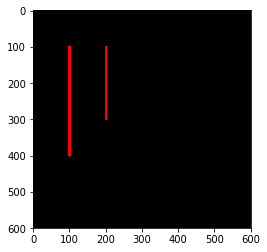

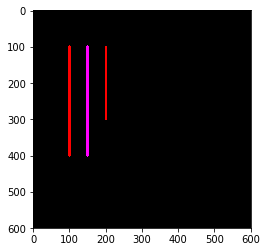

use x
('real lines angle:', 180.0, 180.0)
('initial endpoints:', [(100, 100), (400, 100)], [(200, 300), (350, 300)])
('final line endpoints:', (100, 200), (400, 200))


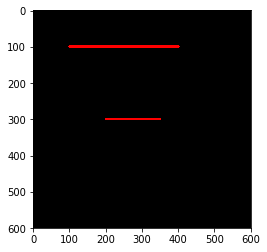

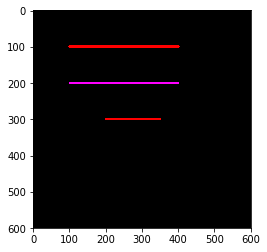

[(100, 200), (400, 200)]

In [34]:
merge_line_segments1([(100,100),(100,400)], [(200,100),(200,300)], True)
merge_line_segments1([(100,100),(400,100)], [(200,300),(350,300)], True)

In [35]:
def merge_lines_pipeline(lines):
    super_lines = []
    min_distance_to_merge = 30
    min_angle_to_merge = 30
    debug = False
    
    for line in lines:
        create_super_line = True
        for idx, super_line in enumerate(super_lines):
            # check the distance between lines
            if get_distance(super_line, line) < min_distance_to_merge:
                # check the angle between lines       
                orientation_i = math.atan2((line[0][1]-line[1][1]),(line[0][0]-line[1][0]))
                orientation_j = math.atan2((super_line[0][1]-super_line[1][1]),(super_line[0][0]-super_line[1][0]))
                
                if int(abs(abs(math.degrees(orientation_i)) - abs(math.degrees(orientation_j)))) < min_angle_to_merge: 
                    #print("angles", orientation_i, orientation_j)
                    #print(int(abs(orientation_i - orientation_j)))
                    new_line = merge_line_segments1(super_line, line, debug)
                    super_lines[idx] = new_line
                    create_super_line = False
                    #break # go to next line
        if (create_super_line):
            # create new super line if we could not find close line and merge
            super_lines.append(line)

    return super_lines

In [36]:
# http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
# http://docs.opencv.org/trunk/d7/d4d/tutorial_py_thresholding.html
def get_lines(lines_in):
    if cv2.__version__ < '3.0':
        return lines_in[0]
    return [l[0] for l in lines_in]

def process_lines(image_src):
    img = mpimg.imread(image_src)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    ret, thresh1 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
    
    thresh1 = cv2.bitwise_not(thresh1)
    
    edges = cv2.Canny(thresh1, threshold1=50, threshold2=200, apertureSize = 3)

    lines = cv2.HoughLinesP(thresh1, rho=5, theta=np.pi/180, threshold=10,
                            minLineLength=100, maxLineGap=30)

    # l[0] - line; l[1] - angle
    for line in get_lines(lines):
        leftx, boty, rightx, topy = line
        cv2.line(img, (leftx, boty), (rightx,topy), (0,0,255), 1)
        
    # merge lines
    _lines = []
    for _line in get_lines(lines):
        _lines.append([(_line[0], _line[1]),(_line[2], _line[3])])
        
    _lines = sorted(_lines, key=lambda _line: _line[0][0])
        
    merged_lines = merge_lines_pipeline(_lines)
    print("process lines", len(lines), len(merged_lines))
    img_merged_lines = mpimg.imread(image_src)
    for line in merged_lines:
        cv2.line(img_merged_lines, (line[0][0], line[0][1]), (line[1][0],line[1][1]), (0,0,255), 6)
        
        #img_merged_lines_temp = mpimg.imread(image_src)
        #cv2.line(img_merged_lines_temp, (line[0][0], line[0][1]), (line[1][0],line[1][1]), (0,0,255), 6)      
        #plt.imshow(img_merged_lines_temp)
        #plt.show()
    
    cv2.imwrite('prediction/lines_gray.jpg',gray)
    cv2.imwrite('prediction/lines_thresh.jpg',thresh1)
    cv2.imwrite('prediction/lines_edges.jpg',edges)
    cv2.imwrite('prediction/lines_lines.jpg',img)
    cv2.imwrite('prediction/merged_lines.jpg',img_merged_lines)
    
    if(True):
        merged_lines2 = merge_lines_pipeline(merged_lines)
        print("process lines 2", len(merged_lines), len(merged_lines2))
        img_merged_lines2 = mpimg.imread(image_src)
        for line in merged_lines2:
            cv2.line(img_merged_lines2, (line[0][0], line[0][1]), (line[1][0],line[1][1]), (0,0,255), 6)

        merged_lines3 = merge_lines_pipeline(merged_lines2)
        print("process lines 3", len(merged_lines2), len(merged_lines3))
        img_merged_lines3 = mpimg.imread(image_src)
        for line in merged_lines3:
            cv2.line(img_merged_lines3, (line[0][0], line[0][1]), (line[1][0],line[1][1]), (0,0,255), 6)

        cv2.imwrite('prediction/merged_lines2.jpg',img_merged_lines2)
        cv2.imwrite('prediction/merged_lines3.jpg',img_merged_lines3)

# Run

In [ ]:
model = train_model()

In [ ]:
#test_model(model, "test_data/a2.JPG")

In [39]:
img_to_test = "test_data/to_test/t2.JPG"

(3024, 4032, 3)
(3024, 4032, 3)
(3072, 4032, 3)
3024


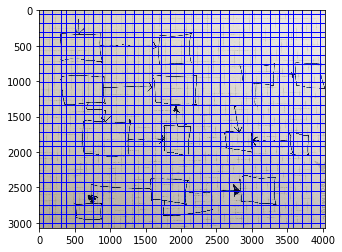

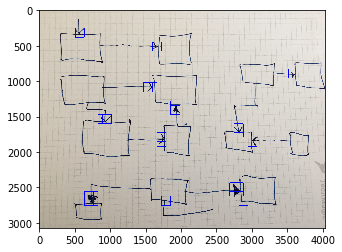

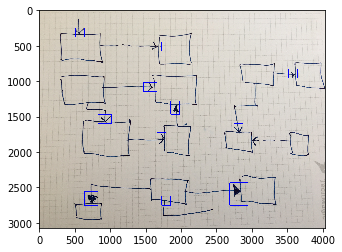

In [40]:
pipeline_vision_single(model, img_to_test, scale=1)

In [41]:
process_lines(img_to_test)

('process lines', 565, 90)
('process lines 2', 90, 82)
('process lines 3', 82, 82)
